# Análise de Qualidade do Ar com Lógica Fuzzy

Este notebook lê os dados filtrados, aplica regras fuzzy e visualiza a distribuição de qualidade do ar.

In [ ]:
# 1. Importações e leitura dos dados
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import os
import zipfile

# Descompactar o arquivo ZIP
zip_path = 'air+quality.zip'
extract_path = 'air_quality_data'

if os.path.exists(os.path.join(extract_path, 'AirQualityUCI.csv')):
    print("O arquivo já foi descompactado anteriormente. Pulando a descompactação.")
else:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Caminho do CSV dentro da pasta
csv_path = os.path.join(extract_path, 'AirQualityUCI.csv')

df = pd.read_csv(csv_path, sep=';', decimal=',', encoding='latin1')

df = df[['Date', 'Time', 'CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']]

df.columns = ['Data','Hora','CO','NOx','NO2','C6H6']

for c in ['CO','NOx','NO2','C6H6']:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    df[c] = df[c].mask(df[c] == -200)
df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Hora'], format='%d/%m/%Y %H.%M.%S', errors='coerce')

df.dropna(subset=['Timestamp','CO','NOx','NO2','C6H6'], inplace=True)

df.set_index('Timestamp', inplace=True)

df.head()

O arquivo já foi descompactado anteriormente. Pulando a descompactação.


,Data,Hora,CO,NOx,NO2,C6H6
Timestamp,,,,,,
2004-03-10 18:00:00,10/03/2004,18.00.00,2.6,166.0,113.0,11.9
2004-03-10 19:00:00,10/03/2004,19.00.00,2.0,103.0,92.0,9.4
2004-03-10 20:00:00,10/03/2004,20.00.00,2.2,131.0,114.0,9.0
2004-03-10 21:00:00,10/03/2004,21.00.00,2.2,172.0,122.0,9.2
2004-03-10 22:00:00,10/03/2004,22.00.00,1.6,131.0,116.0,6.5


In [30]:
# 2. Definição do sistema fuzzy
co = ctrl.Antecedent(np.arange(0, 12.1, 0.1), 'CO')
nox = ctrl.Antecedent(np.arange(0, 1501, 1), 'NOx')
no2 = ctrl.Antecedent(np.arange(0, 351, 1), 'NO2')
c6h6 = ctrl.Antecedent(np.arange(0, 65.1, 0.1), 'C6H6')
qualidade = ctrl.Consequent(np.arange(0, 101, 1), 'qualidade')

# Funções de pertinência
co['baixo'] = fuzz.trimf(co.universe,[0,0,3])
co['medio'] = fuzz.trimf(co.universe,[2,4.5,7])
co['alto'] = fuzz.trimf(co.universe,[6,12,12])

nox['baixo'] = fuzz.trimf(nox.universe,[0,0,200])
nox['medio'] = fuzz.trimf(nox.universe,[150,400,650])
nox['alto'] = fuzz.trimf(nox.universe,[600,1500,1500])

no2['baixo'] = fuzz.trimf(no2.universe,[0,0,80])
no2['medio'] = fuzz.trimf(no2.universe,[60,150,240])
no2['alto'] = fuzz.trimf(no2.universe,[200,350,350])

c6h6['baixo'] = fuzz.trimf(c6h6.universe,[0,0,5])
c6h6['medio'] = fuzz.trimf(c6h6.universe,[4,15,30])
c6h6['alto'] = fuzz.trimf(c6h6.universe,[25,65,65])

qualidade['boa'] = fuzz.trimf(qualidade.universe, [0, 0, 30])
qualidade['moderada'] = fuzz.trimf(qualidade.universe, [20, 45, 60])
qualidade['ruim'] = fuzz.trimf(qualidade.universe, [50, 70, 85])
qualidade['perigosa'] = fuzz.trimf(qualidade.universe, [80, 100, 100])

# 3. Regras fuzzy
regras = [
    ctrl.Rule(co['alto'] | nox['alto'] | c6h6['alto'], qualidade['perigosa']),
    ctrl.Rule(co['medio'] | nox['medio'] | no2['alto'], qualidade['ruim']),
    ctrl.Rule(no2['medio'] & c6h6['medio'], qualidade['moderada']),
    ctrl.Rule(co['baixo'] & nox['baixo'] & no2['baixo'] & c6h6['baixo'], qualidade['boa']),
]

sistema_ctrl = ctrl.ControlSystem(regras)


In [33]:
# 4. Função de aplicação linha a linha
erros = []

def avaliar_qualidade_debug(row):
    try:
        sim = ctrl.ControlSystemSimulation(sistema_ctrl)
        sim.input['CO'] = float(row['CO'])
        sim.input['NOx'] = float(row['NOx'])
        sim.input['NO2'] = float(row['NO2'])
        sim.input['C6H6'] = float(row['C6H6'])
        sim.compute()
        return sim.output['qualidade']
    except Exception as e:
        erros.append((row.name, str(e)))
        print(f"Erro ao processar a linha {row.name}: {e}")
        return np.nan

df_filtered = df[
    (df['CO'] >= 0) & (df['CO'] <= 12) &
    (df['NOx'] >= 0) & (df['NOx'] <= 1500) &
    (df['NO2'] >= 0) & (df['NO2'] <= 350) &
    (df['C6H6'] >= 0) & (df['C6H6'] <= 65)
].copy()


df_filtered['qualidade_ar'] = df_filtered.apply(avaliar_qualidade_debug, axis=1)

# 5. Classificação linguística
def classificar(valor):
    if pd.isna(valor):
        return 'indefinido'
    elif valor <= 30:
        return 'boa'
    elif valor <= 60:
        return 'moderada'
    elif valor <= 85:
        return 'ruim'
    else:
        return 'perigosa'

df_filtered['classificacao'] = df_filtered['qualidade_ar'].apply(classificar)

Erro ao processar a linha 2004-03-11 07:00:00: 'qualidade'
Erro ao processar a linha 2004-03-25 07:00:00: 'qualidade'
Erro ao processar a linha 2004-03-26 02:00:00: 'qualidade'
Erro ao processar a linha 2004-03-28 21:00:00: 'qualidade'
Erro ao processar a linha 2004-03-28 22:00:00: 'qualidade'
Erro ao processar a linha 2004-03-29 21:00:00: 'qualidade'
Erro ao processar a linha 2004-03-29 22:00:00: 'qualidade'
Erro ao processar a linha 2004-03-30 22:00:00: 'qualidade'
Erro ao processar a linha 2004-03-31 00:00:00: 'qualidade'
Erro ao processar a linha 2004-03-31 06:00:00: 'qualidade'
Erro ao processar a linha 2004-04-11 18:00:00: 'qualidade'
Erro ao processar a linha 2004-04-11 23:00:00: 'qualidade'
Erro ao processar a linha 2004-04-12 11:00:00: 'qualidade'
Erro ao processar a linha 2004-04-12 16:00:00: 'qualidade'
Erro ao processar a linha 2004-04-12 18:00:00: 'qualidade'
Erro ao processar a linha 2004-04-12 20:00:00: 'qualidade'
Erro ao processar a linha 2004-05-02 02:00:00: 'qualidad

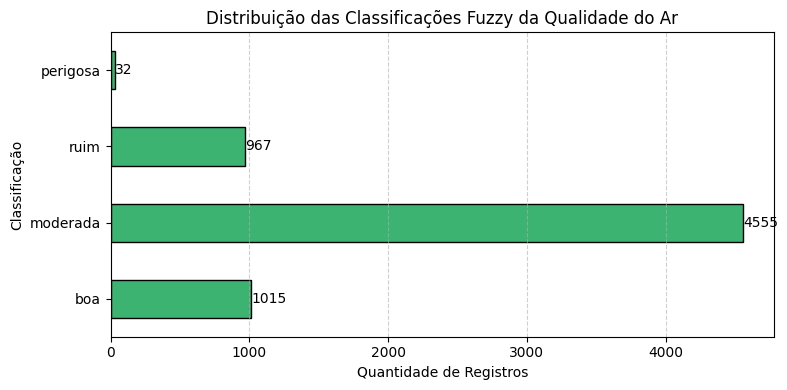

In [ ]:
# 6. Gráfico de distribuição das classificações fuzzy na base de dados
import matplotlib.pyplot as plt

# Contagem das classificações
contagem = df_filtered['classificacao'].value_counts().reindex(['boa', 'moderada', 'ruim', 'perigosa'])

# Criar gráfico
plt.figure(figsize=(8, 4))
bars = contagem.plot(kind='barh', color='mediumseagreen', edgecolor='black')

# Adicionar texto com os valores ao lado das barras
for index, value in enumerate(contagem):
    plt.text(value + 2, index, str(int(value)), va='center', fontsize=10)

# Estilização
plt.title('Distribuição das Classificações Fuzzy da Qualidade do Ar')
plt.xlabel('Quantidade de Registros')
plt.ylabel('Classificação')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
